# Задание 1                
#### Retention – один из самых важных показателей в компании. 
#### Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib
from datetime import date, datetime, timedelta

In [6]:
#загружаем данные времени регистрации и времени захода пользователя в игру
time_reg=pd.DataFrame(pd.read_csv('reg_data.csv', sep=";"))
visiting_time=pd.DataFrame(pd.read_csv('auth_data.csv', sep=";"))

смотрим общую информацию: размер данных, типы, нулевые значения

In [8]:
time_reg.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [9]:
visiting_time.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [10]:
visiting_time.shape

(9601013, 2)

In [11]:
time_reg.shape

(1000000, 2)

In [12]:
time_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [13]:
visiting_time.dtypes

auth_ts    int64
uid        int64
dtype: object

In [14]:
time_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [15]:
visiting_time.isna().sum()

auth_ts    0
uid        0
dtype: int64

преобразовываем формат дат во всех датафреймах, посмотрим первую дату регистрации и последнюю

In [17]:
time_reg['reg_ts']=pd.to_datetime(time_reg['reg_ts'], unit='s')
visiting_time['auth_ts']=pd.to_datetime(visiting_time['auth_ts'], unit='s') 

In [18]:
time_reg['reg_ts'].min()

Timestamp('1998-11-18 09:43:43')

In [19]:
visiting_time['auth_ts'].min()

Timestamp('1998-11-18 09:43:43')

In [20]:
time_reg['reg_ts'].max()

Timestamp('2020-09-23 15:17:24')

In [21]:
## Напишем функцию дневного retention для заданного периода

In [22]:
def retention (first_date, last_date, time_reg=time_reg, auth_time=visiting_time):
    
    
    '''отбираем период'''
    visiting_time = auth_time.query("@first_date <= auth_ts <= @last_date")
    time_reg = time_reg.query("@first_date <= reg_ts <= @last_date")
    '''мержим датафреймы'''
    df_total=time_reg.merge(visiting_time,on='uid',how='inner')
  
    '''определим разницу в днях, подготовим данные'''
    df_total['day_delta']=(df_total['auth_ts']-df_total['reg_ts']).dt.days
    
    '''так как это игровая аналитика, предпочтительнее считать retention 1, 7 и 14 дня, 
    поэтому не рассматриваем разницу более 30 дней'''
    
    df_total['day_delta']= df_total['day_delta'].apply(lambda x: x if x <=30 else 'nothing')
    df_total=df_total.query('day_delta!="nothing"')
    df_total.reg_ts=df_total.reg_ts.astype('str')
    df_total['reg_ts'] = df_total['reg_ts'].apply(lambda x: x[:10])
    '''в датафрейм добавим столбец retention co значением 1 для сводной таблицы'''
    df_total['retention'] = 1
    '''сделаем pivot'''
    pivot_retention = pd.pivot_table(df_total, index='reg_ts', columns='day_delta', values='retention', aggfunc=pd.Series.sum)
    ''' Вычислим ретеншн и удалим 0 день'''
    df_retention = pivot_retention.divide(pivot_retention[0], axis=0).mul(100).round(2).drop([0], axis=1)
   
    
    '''выполним преобразования и визуализируем таблицу retention  и построим тепловой график'''
    
    sns.set(style='ticks',
        rc={"figure.figsize": (25, 12)})
    plt.title('Retention')
    sns.heatmap(data=df_retention.div(100, axis=0), annot=True, cmap="GnBu", fmt='.0%', linewidths=0.1)
    return df_retention

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

day_delta,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-10,3.53,4.58,5.82,5.89,6.28,7.39,4.45,5.10,4.97,6.02,...,2.68,3.73,3.47,4.38,2.68,3.40,3.79,2.75,3.34,2.49
2020-08-11,3.72,4.77,4.77,6.79,7.38,8.49,4.50,6.33,5.48,6.14,...,4.50,3.66,4.44,3.00,4.11,3.33,2.48,3.52,2.87,2.94
2020-08-12,4.11,3.59,3.19,4.37,5.67,5.87,3.91,4.30,4.04,4.17,...,4.24,2.48,3.46,2.87,3.26,2.93,2.74,2.54,1.89,2.09
2020-08-13,3.51,3.90,5.99,5.60,5.79,7.29,4.10,5.86,5.07,5.27,...,3.51,3.97,2.80,3.19,3.45,3.45,3.12,2.15,3.12,2.80
2020-08-14,3.25,3.70,5.39,7.08,5.33,7.41,4.16,5.39,4.61,5.00,...,3.70,3.83,3.57,3.51,3.57,2.92,2.40,3.44,2.14,3.25
2020-08-15,4.22,3.83,5.58,5.51,7.00,7.78,3.89,5.45,4.67,5.58,...,4.15,3.76,3.50,4.15,3.11,3.83,3.44,2.66,3.24,1.75
2020-08-16,3.50,3.37,4.85,5.24,6.21,6.54,3.88,4.66,5.24,5.57,...,3.24,3.69,2.91,2.72,3.24,3.37,3.11,2.98,1.36,NaN
2020-08-17,4.27,3.75,4.91,5.75,5.49,7.24,3.81,5.04,4.27,5.82,...,3.81,4.14,3.68,3.10,3.43,3.10,3.30,1.10,NaN,NaN
2020-08-18,4.33,3.87,5.29,5.42,6.07,7.17,4.52,5.49,4.91,5.94,...,4.39,3.94,3.10,4.65,3.42,3.55,1.68,NaN,NaN,NaN


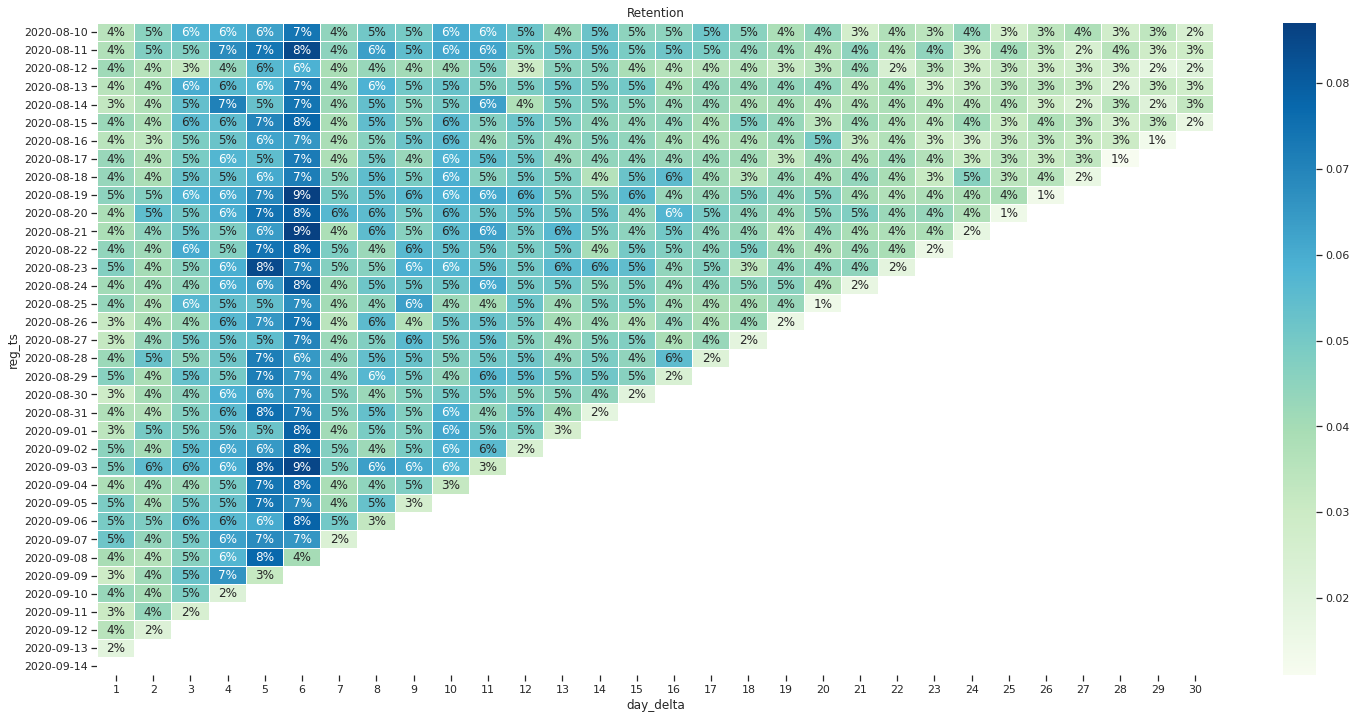

In [23]:
retention ('2020-08-10','2020-09-15')

Вывод: Функция retention получает на вход 2 датафрейма с датой регистрации и датой захода пользователя в игру и интересующий нас период. 
Данная функция может посчитать дневной retention на любом сэмпле дат.
В итоге получаем "косынку" со значениями и для наглядности тепловой график.

→ 1-day retention. Если много пользователей не открывают приложение на следующий день после установки, возможно в нем что-то сломалось, есть проблемы с интерфейсом или оно им просто неинтересно.

→ 7-day retention. Если через неделю после установки люди перестают пользоваться приложением, то нужно понять, на каком именно этапе они отваливаются.

→ 28-day retention. Если через месяц люди почти не возвращаются в приложение, то возможно стоит пересмотреть маркетинговую и продуктовую стратегию.